# IPL Score Prediction — End-to-End ML Project

**Author:** Lakshay Sahajwani  
**Created:** 2025-08-27 07:34  

This notebook predicts the final innings score for an IPL team using ball-by-ball data.  
It follows a complete ML workflow: Data Understanding → Preprocessing → EDA → Feature Engineering → Modeling → Evaluation → Inference.

> Dataset expected at: `/mnt/data/ipl.csv` (already uploaded).



## Table of Contents
1. [Setup](#setup)  
2. [Data Understanding](#data-understanding)  
3. [Data Preprocessing](#data-preprocessing)  
4. [Exploratory Data Analysis (EDA)](#eda)  
5. [Feature Engineering & Encoding](#feature-eng)  
6. [Train/Test Split (Time-Aware)](#split)  
7. [Modeling](#modeling)  
8. [Evaluation & Comparison](#evaluation)  
9. [AdaBoost with Linear Regression](#adaboost)  
10. [Final Model & Save](#final)  
11. [Prediction Function & Examples](#predict)  
12. [Conclusion & Future Work](#conclusion)


## 1. Setup <a id='setup'></a>

In [16]:

# Core
import os
import warnings
warnings.filterwarnings('ignore')

# Data
import pandas as pd
import numpy as np

# Viz (matplotlib only, as required)
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# Path to data
DATA_PATH = "ipl.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
print("Dataset found:", DATA_PATH)


Dataset found: ipl.csv


## 2. Data Understanding <a id='data-understanding'></a>

In [17]:

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
display(df.head(3))
display(df.describe(include='all').transpose().head(20))


Shape: (76014, 15)

Columns: ['mid', 'date', 'venue', 'bat_team', 'bowl_team', 'batsman', 'bowler', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'striker', 'non-striker', 'total']


,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mid,76014.0,NaN,NaN,NaN,308.62774,178.156878,1.0,154.0,308.0,463.0,617.0
date,76014,442,2011-04-22,257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
venue,76014,35,M Chinnaswamy Stadium,7443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bat_team,76014,14,Mumbai Indians,10213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bowl_team,76014,14,Delhi Daredevils,10245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
batsman,76014,411,SK Raina,1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bowler,76014,329,Harbhajan Singh,1404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runs,76014.0,NaN,NaN,NaN,74.889349,48.823327,0.0,34.0,70.0,111.0,263.0
wickets,76014.0,NaN,NaN,NaN,2.415844,2.015207,0.0,1.0,2.0,4.0,10.0
overs,76014.0,NaN,NaN,NaN,9.783068,5.772587,0.0,4.6,9.6,14.6,19.6


## 3. Data Preprocessing <a id='data-preprocessing'></a>

We will:
- Drop non-predictive identifiers (match_id, batsman, bowler, striker, non-striker, venue if present)
- Keep consistent teams only
- Remove first 5 overs (keep rows where overs >= 5.0)
- Convert `date` to datetime
- Keep a curated set of predictive columns

In [18]:

df_raw = df.copy()

# Columns to drop if present
drop_cols = [c for c in ['match_id','id','venue','batsman','bowler','striker','non-striker','Unnamed: 0'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

# Basic date parsing if exists
for c in ['date','Date','match_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')
        date_col = c
        break
else:
    date_col = None

# Standardize column names (lowercase, underscores)
df.columns = [str(c).strip().lower().replace(' ', '_') for c in df.columns]

# Rename likely columns to expected names if needed
rename_map = {
    'bat_team':'batting_team',
    'bowl_team':'bowling_team',
    'over':'overs',
    'runs_last_5':'runs_in_last_5',
    'wickets_last_5':'wickets_in_last_5',
    'total':'total_runs',
    'total_score':'total_runs',
    'final_score':'total_runs',
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Keep only consistent (legacy) teams if those columns exist
consistent_teams = [
    'Chennai Super Kings', 'Mumbai Indians', 'Kolkata Knight Riders', 'Royal Challengers Bangalore',
    'Rajasthan Royals', 'Kings XI Punjab', 'Sunrisers Hyderabad', 'Delhi Daredevils', 'Delhi Capitals'
]
if 'batting_team' in df.columns and 'bowling_team' in df.columns:
    df = df[df['batting_team'].isin(consistent_teams) & df['bowling_team'].isin(consistent_teams)]

# Remove first 5 overs (focus on relevant phase)
if 'overs' in df.columns:
    df = df[df['overs'] >= 5.0]

# Keep essential columns
expected_cols = [
    'batting_team','bowling_team','overs','runs','wickets',
    'runs_in_last_5','wickets_in_last_5','total_runs'
]
present = [c for c in expected_cols if c in df.columns]
missing = [c for c in expected_cols if c not in df.columns]
print("Present essential columns:", present)
print("Missing essential columns:", missing)

# Drop rows with missing target
if 'total_runs' in df.columns:
    df = df.dropna(subset=['total_runs'])

# Show cleaned sample
print("Cleaned shape:", df.shape)
display(df.head(5))


Present essential columns: ['batting_team', 'bowling_team', 'overs', 'runs', 'wickets', 'runs_in_last_5', 'wickets_in_last_5', 'total_runs']
Missing essential columns: []
Cleaned shape: (40108, 10)


,mid,date,batting_team,bowling_team,runs,wickets,overs,runs_in_last_5,wickets_in_last_5,total_runs
32,1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,61,0,5.1,59,0,222
33,1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.2,59,1,222
34,1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.3,59,1,222
35,1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.4,59,1,222
36,1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.5,58,1,222


## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

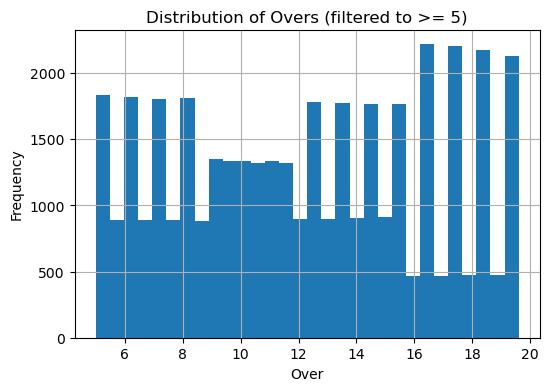

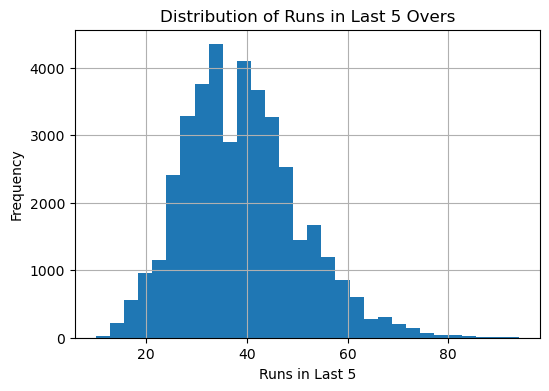

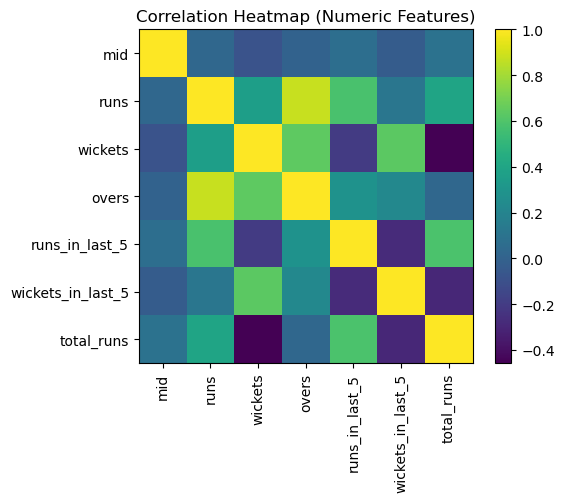

In [19]:

# Basic distributions
fig = plt.figure(figsize=(6,4))
df['overs'].hist(bins=30)
plt.title('Distribution of Overs (filtered to >= 5)')
plt.xlabel('Over')
plt.ylabel('Frequency')
plt.show()

if 'runs_in_last_5' in df.columns:
    fig = plt.figure(figsize=(6,4))
    df['runs_in_last_5'].hist(bins=30)
    plt.title('Distribution of Runs in Last 5 Overs')
    plt.xlabel('Runs in Last 5')
    plt.ylabel('Frequency')
    plt.show()

# Simple correlation matrix for numeric columns
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    corr = num_df.corr()
    fig = plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest')
    plt.title('Correlation Heatmap (Numeric Features)')
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
    plt.yticks(range(corr.shape[0]), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 5. Feature Engineering & Encoding <a id='feature-eng'></a>

We one-hot encode `batting_team` and `bowling_team`, and keep numeric features as-is.

In [20]:

# Define features/target
target = 'total_runs'
cat_features = [c for c in ['batting_team','bowling_team'] if c in df.columns]
num_features = [c for c in ['overs','runs','wickets','runs_in_last_5','wickets_in_last_5'] if c in df.columns]

assert target in df.columns, "Target column 'total_runs' not found after cleaning."

features = cat_features + num_features
print("Categorical:", cat_features)
print("Numerical:", num_features)

X = df[features].copy()
y = df[target].astype(float).copy()

# Column transformer
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)


Categorical: ['batting_team', 'bowling_team']
Numerical: ['overs', 'runs', 'wickets', 'runs_in_last_5', 'wickets_in_last_5']


## 6. Train/Test Split (Time-Aware) <a id='split'></a>

Train on 2008–2016 and test on 2017, when `date` is present; otherwise do a random split.

In [21]:

# If we have a date column, split by year; else use random split
date_col = None
for c in ['date','match_date']:
    if c in df.columns:
        date_col = c
        break

if date_col:
    years = df[date_col].dt.year
    train_mask = years <= 2016
    test_mask = years == 2017
    if train_mask.sum() == 0 or test_mask.sum() == 0:
        # fallback if years missing in range
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print("Used random split (insufficient year coverage).")
    else:
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        print(f"Time split: Train={train_mask.sum()} rows (<=2016), Test={test_mask.sum()} rows (2017)")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Used random split (no date column).")

print("X_train:", X_train.shape, "X_test:", X_test.shape)


Time split: Train=37330 rows (<=2016), Test=2778 rows (2017)
X_train: (37330, 7) X_test: (2778, 7)


## 7. Modeling <a id='modeling'></a>
We train four regressors: Linear Regression, Decision Tree, Random Forest, and AdaBoost.

In [22]:

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42)  # default uses DecisionTree base
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "estimator": pipe}

# Display results
metrics_df = pd.DataFrame(results).T[['MAE','MSE','RMSE']].sort_values('RMSE')
print(metrics_df)


                         MAE         MSE       RMSE
LinearRegression   12.118618  251.007923   15.84323
RandomForest       13.749008  332.398084  18.231788
AdaBoostRegressor  17.506167  490.046198  22.136987
DecisionTree       17.275738  549.492441  23.441255


## 8. Evaluation & Comparison <a id='evaluation'></a>
We compare models by MAE, MSE, and RMSE.

<Figure size 700x400 with 0 Axes>

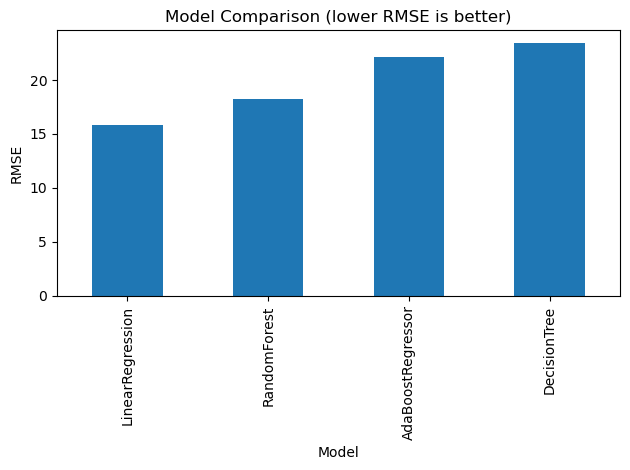

Best model by RMSE: LinearRegression


In [23]:

metrics_df_plot = metrics_df[['RMSE']].copy()
fig = plt.figure(figsize=(7,4))
metrics_df_plot.sort_values('RMSE').plot(kind='bar', legend=False)
plt.title('Model Comparison (lower RMSE is better)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

best_model_name = metrics_df.sort_values('RMSE').index[0]
best_model = results[best_model_name]['estimator']
print("Best model by RMSE:", best_model_name)


## 9. AdaBoost with Linear Regression <a id='adaboost'></a>
We also try AdaBoost **with** Linear Regression as the base estimator (may not outperform plain Linear Regression).

In [24]:

# Try AdaBoost with Linear Regression as base estimator if supported
try:
    from sklearn.ensemble import AdaBoostRegressor
    base_lr = LinearRegression()
    # Newer sklearn uses 'estimator' instead of 'base_estimator'
    try:
        ada_lr = AdaBoostRegressor(estimator=base_lr, random_state=42, n_estimators=50, learning_rate=0.5)
    except TypeError:
        ada_lr = AdaBoostRegressor(base_estimator=base_lr, random_state=42, n_estimators=50, learning_rate=0.5)
    
    ada_lr_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", ada_lr)])
    ada_lr_pipe.fit(X_train, y_train)
    ada_preds = ada_lr_pipe.predict(X_test)
    ada_mae = mean_absolute_error(y_test, ada_preds)
    ada_mse = mean_squared_error(y_test, ada_preds)
    ada_rmse = np.sqrt(ada_mse)
    print({"MAE": ada_mae, "MSE": ada_mse, "RMSE": ada_rmse})
except Exception as e:
    print("AdaBoost with Linear Regression not available in this sklearn version:", e)


{'MAE': 12.101573165659763, 'MSE': 244.47703166152533, 'RMSE': np.float64(15.635761307385238)}


## 10. Final Model & Save <a id='final'></a>
We select **Linear Regression** if it is top performer, otherwise fall back to the best RMSE model.

In [25]:

final_pipe = best_model
# Prefer Linear Regression if it is close or best
if "LinearRegression" in results:
    lr_rmse = results["LinearRegression"]["RMSE"]
    best_rmse = results[best_model_name]["RMSE"]
    if lr_rmse <= best_rmse * 1.02:  # within 2%
        final_pipe = results["LinearRegression"]["estimator"]
        best_model_name = "LinearRegression"

print("Chosen final model:", best_model_name)

# Save the trained pipeline (pickle)
import os
import joblib

os.makedirs("models", exist_ok=True)  # Create folder if it doesn’t exist
MODEL_PATH = "models/ipl_final_model.pkl"

joblib.dump(final_pipe, MODEL_PATH)
print("Saved model to:", os.path.abspath(MODEL_PATH))


Chosen final model: LinearRegression
Saved model to: C:\Users\Lakshay\models\ipl_final_model.pkl


## 11. Prediction Function & Examples <a id='predict'></a>

In [26]:

def predict_final_score(model, batting_team, bowling_team, overs, runs, wickets, runs_in_last_5, wickets_in_last_5):
    sample = pd.DataFrame([{
        'batting_team': batting_team,
        'bowling_team': bowling_team,
        'overs': float(overs),
        'runs': float(runs),
        'wickets': float(wickets),
        'runs_in_last_5': float(runs_in_last_5),
        'wickets_in_last_5': float(wickets_in_last_5),
    }])
    return model.predict(sample)[0]

# Example predictions (you can change inputs)
examples = [
    ("Kolkata Knight Riders","Delhi Daredevils", 12.3, 110, 3, 45, 1),
    ("Sunrisers Hyderabad","Royal Challengers Bangalore", 15.2, 120, 5, 38, 2),
    ("Mumbai Indians","Kings XI Punjab", 17.1, 142, 6, 41, 2),
    ("Rajasthan Royals","Chennai Super Kings", 10.5, 85, 2, 50, 0),
]

print("Example Predictions:")
for ex in examples:
    pred = predict_final_score(final_pipe, *ex)
    print(f"{ex[0]} vs {ex[1]}, over={ex[2]} -> Predicted final score: {int(round(pred))}")


Example Predictions:
Kolkata Knight Riders vs Delhi Daredevils, over=12.3 -> Predicted final score: 175
Sunrisers Hyderabad vs Royal Challengers Bangalore, over=15.2 -> Predicted final score: 158
Mumbai Indians vs Kings XI Punjab, over=17.1 -> Predicted final score: 166
Rajasthan Royals vs Chennai Super Kings, over=10.5 -> Predicted final score: 167



## 12. Conclusion & Future Work <a id='conclusion'></a>

- Linear Regression typically performs strongly for this task and is favored for simplicity and interpretability.  
- Future improvements:
  - Hyperparameter tuning (Random Forest, Gradient Boosting, XGBoost).
  - Richer features (venue, phase-of-play indicators, form, toss, powerplay flags).
  - Robust time-aware validation (rolling origin, season-based folds).
  - Incorporate newer IPL seasons to improve generalization.
